In [1]:
# [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [2]:
# Step by Step Approach
# 1. Import libraries
# 2. Visualize Data
# 3. Load Data
# 4. Build Model
# 5. Train & Evaluate the Model

### Step 1: Import Libraries

In [3]:
# Libraries

import os
from time import time
from tqdm import tqdm
import numpy

import torch
from torch.nn import Linear, CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import datasets
from torchvision.models import resnet18
from torchvision.transforms import transforms

import matplotlib.pyplot as plt

#from PIL import Image

/home/azad/anaconda3/envs/bnn/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Step 3: Set Processing Device

In [4]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cpu


### Step 3: Load Data
1. Data Transformer
2. Create Dataset
3. Data Loader

In [5]:
# dataset transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(p=0.5),
    #transforms.RandomVerticalFlip(p=0.5),
    #transforms.RandomRotation(degrees=(30, 70)),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
# create dataset
root_dir = "data/Mushrooms/"
dataset = datasets.ImageFolder(
    root = root_dir,
    transform = train_transform
)

In [7]:
# length of datasets
print(len(dataset))

# index mapping
print(dataset.class_to_idx)

6714
{'Agaricus': 0, 'Amanita': 1, 'Boletus': 2, 'Cortinarius': 3, 'Entoloma': 4, 'Hygrocybe': 5, 'Lactarius': 6, 'Russula': 7, 'Suillus': 8}


In [8]:
# data loader
BATCH_SIZE = 16
dataset_loader = torch.utils.data.DataLoader(
    dataset, batch_size=BATCH_SIZE, shuffle=True
)

### visualize dataloader

images batch shape  : torch.Size([16, 3, 224, 224])
Labels batch shape  : torch.Size([16])
single image shape  : torch.Size([3, 224, 224])
single label shape  : torch.Size([])


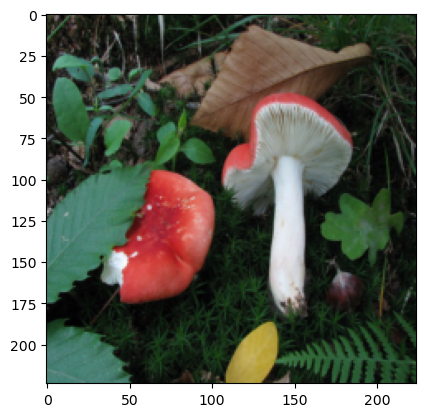

Label: Russula


In [9]:
labels_map = {
    0: 'Agaricus', 
    1: 'Amanita', 
    2: 'Boletus', 
    3: 'Cortinarius', 
    4: 'Entoloma', 
    5: 'Hygrocybe', 
    6: 'Lactarius', 
    7: 'Russula', 
    8: 'Suillus'
}

# Display image and label.
features, labels = next(iter(dataset_loader))
print(f"images batch shape  : {features.size()}")
print(f"Labels batch shape  : {labels.size()}")

img = features[0].squeeze()
label = labels[0]
print(f"single image shape  : {img.shape}")
print(f"single label shape  : {label.shape}")

plt.imshow(img.permute(1,2,0), cmap="gray")
plt.show()
print(f"Label: {labels_map[label.item()]}")

## Step 4: Build Model, Optimiser and Loss Function

In [10]:
from torchvision.models import resnet18, ResNet18_Weights
# ResNet architecture
#model = resnet18(weights=ResNet18_Weights)                 # ????
#model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)   # specific version of weights
model = resnet18(weights=ResNet18_Weights.DEFAULT)         # best available weights
#model = resnet18(weights=None)                             # using no weights
model.fc = torch.nn.Linear(in_features=512, out_features=24)
#preprocess = ResNet18_Weights.DEFAULT.transforms()
model = model.to(device)

# old way - deprecated
'''
model = resnet18(pretrained=True)

# Replace Output of Fully Connected Layer with Number of Labels for our Classification Problem
model.fc = Linear(in_features=512, out_features=2)
model = model.to(device)
# model = model.cuda()    # only if your system supports Nvidia CUDA
'''

'\nmodel = resnet18(pretrained=True)\n\n# Replace Output of Fully Connected Layer with Number of Labels for our Classification Problem\nmodel.fc = Linear(in_features=512, out_features=2)\nmodel = model.to(device)\n# model = model.cuda()    # only if your system supports Nvidia CUDA\n'

In [11]:
# Optimiser
optimiser = Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

# Loss Function
loss_fn = CrossEntropyLoss()

## Step 5: Train & Evaluate the Model


In [12]:
for epoch in range(2):
    #start = time()
    
    tr_acc = 0
    test_acc = 0
    
    # Train
    model.train()
    
    with tqdm(dataset_loader, unit="batch") as tepoch:
        for xtrain, ytrain in tepoch:
            optimiser.zero_grad()
            
            xtrain = xtrain.to(device)
            train_prob = model(xtrain)
            train_prob = train_prob.cpu()
            
            loss = loss_fn(train_prob, ytrain)
            loss.backward()
            optimiser.step()
            
            # training ends
            
            train_pred = torch.max(train_prob, 1).indices
            tr_acc += int(torch.sum(train_pred == ytrain))
            
        ep_tr_acc = tr_acc / LEN_TRAIN
    
    # Evaluate
    '''
    model.eval()
    with torch.no_grad():
        for xtest, ytest in test_loader:
            xtest = xtest.to(device)
            test_prob = model(xtest)
            test_prob = test_prob.cpu()
            
            test_pred = torch.max(test_prob,1).indices
            test_acc += int(torch.sum(test_pred == ytest))
            
        ep_test_acc = test_acc / LEN_TEST
    '''
    
    #end = time()
    #duration = (end - start) / 60
    
    #print(f"Epoch: {epoch}, Time: {duration}, Loss: {loss}\nTrain_acc: {ep_tr_acc}, Test_acc: {ep_test_acc}")
    print(f"Epoch: {epoch}, Loss: {loss}\nTrain_acc: {ep_tr_acc}")

 15%|█▍        | 62/420 [06:01<34:44,  5.82s/batch]


OSError: image file is truncated (95 bytes not processed)

## Model Performance on Samples

In [12]:
# Image Samples
sample_1 = 'is_that_santa/test/santa/283.Santa.jpg'
sample_2 = 'is_that_santa/test/santa/474.Santa.jpg'
sample_3 = 'is_that_santa/test/not-a-santa/340.not-a-santa.jpg'
sample_4 = 'is_that_santa/test/not-a-santa/58.not-a-santa.jpg'

sample_list = [sample_1, sample_2, sample_3, sample_4]

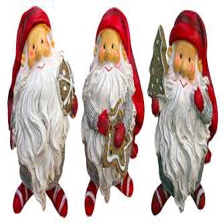

Model prediction 1, hence Santa


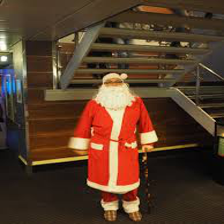

Model prediction 1, hence Santa


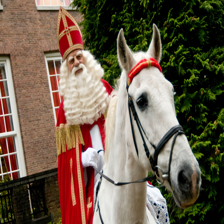

Model prediction 0, hence Not Santa


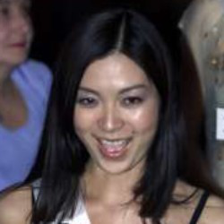

Model prediction 0, hence Not Santa


In [14]:
# Model Performance
from PIL import Image
import numpy as np

for image_path in sample_list:
    img = Image.open(image_path)
    display(img.resize((224,224)))
    img_tensor = tfm(img)
    img_tensor = img_tensor[np.newaxis, :]
    img_tensor = img_tensor.to(device)
    pred_prob = model(img_tensor)
    pred = torch.max(pred_prob,1).indices
    pred = pred.item()
    if pred == 1:
        print(f"Model prediction {pred}, hence Santa")
    else:
        print(f"Model prediction {pred}, hence Not Santa")

    print("========================================================")